## Import  libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
#import optuna
import warnings
import io
import requests
from datetime import datetime
import os
warnings.filterwarnings('ignore')
# Set max_rows to None to display all rows
pd.set_option('display.max_rows', None)

In [2]:
import holidays

# Initialize French holiday calendar
fr_holidays = holidays.France(years=range(2006, 2011))

# Get all holiday dates in the period
holiday_dates = list(fr_holidays.keys())
print(f"French Holidays (2006–2010):\n{holiday_dates[:5]}...")  # Preview first 5

French Holidays (2006–2010):
[datetime.date(2006, 1, 1), datetime.date(2006, 5, 1), datetime.date(2006, 5, 8), datetime.date(2006, 7, 14), datetime.date(2006, 11, 11)]...


## Fetch data from URL....

In [3]:
file_id = "1c222AbSUMn9vKcepLZDnyCKUN2B8BQtP"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url, sep=',', low_memory=False)

In [220]:
# Display the first few rows of the dataset
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset Overview:
Shape: (1441, 11)

First 5 rows:


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions
0,2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy"
1,2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy"
2,2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy
3,2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy
4,2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy


In [221]:
# First, check for problematic values
print("Missing values count:")
print(df.isna().sum())

Missing values count:
datetime                  0
Global_active_power      15
Global_reactive_power    15
Voltage                  15
Global_intensity         15
Sub_metering_1           15
Sub_metering_2           15
Sub_metering_3           15
temp                      0
humidity                  0
conditions                0
dtype: int64


In [222]:
df.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'temp', 'humidity', 'conditions'],
      dtype='object')

In [223]:
def clean_data(df, column):
    # Replace infinites with NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaNs - using forward fill for time series
    df.fillna(method='ffill', inplace=True)
    
    # Handle zero volumes by replacing with previous value
    df[column] = df[column].replace(0, np.nan).fillna(method='ffill')
    
    return df

columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
# Clean the data
for col in columns:
    cleaned_df = clean_data(df, col )

In [224]:
# First, check for problematic values
print("Missing values count:")
print(cleaned_df.isna().sum())

Missing values count:
datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           4
temp                     0
humidity                 0
conditions               0
dtype: int64


In [225]:
import numpy as np
import pandas as pd
from scipy import stats

def detect_outliers(series, method='iqr', window=30, threshold=3):
    """
    Detect outliers using specified method
    """
    if method == 'iqr':
        # IQR method (robust for skewed distributions)
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return (series < lower_bound) | (series > upper_bound)
    
    elif method == 'zscore':
        # Z-score method (for normal distributions)
        z = np.abs(stats.zscore(series))
        return z > threshold
    
    elif method == 'rolling':
        # Time-aware rolling z-score
        mean = series.rolling(window=window, min_periods=1).mean()
        std = series.rolling(window=window, min_periods=1).std()
        z = np.abs((series - mean) / std)
        return z > threshold
    
    elif method == 'mad':
        # Median Absolute Deviation (robust)
        median = series.median()
        mad = np.abs(series - median).median()
        modified_z = 0.6745 * (series - median) / mad
        return np.abs(modified_z) > threshold
    
    else:
        raise ValueError("Invalid method. Choose: 'iqr', 'zscore', 'rolling', 'mad'")
        
def plot_outliers(series, outliers):
    plt.figure(figsize=(14, 6))
    plt.plot(series, label='Original')
    plt.scatter(outliers[outliers].index, 
                series[outliers], 
                color='red', label='Outliers')
    plt.title('Outlier Detection')
    plt.legend()
    plt.show()

def handle_outliers(series, outliers, method='winsorize', **kwargs):
    """
    Handle detected outliers
    """
    cleaned = series.copy()
    
    if method == 'winsorize':
        # Cap extreme values at percentiles
        lower = kwargs.get('lower', 0.05)
        upper = kwargs.get('upper', 0.95)
        lower_bound = series.quantile(lower)
        upper_bound = series.quantile(upper)
        cleaned[outliers & (series < lower_bound)] = lower_bound
        cleaned[outliers & (series > upper_bound)] = upper_bound
    
    elif method == 'impute':
        # Time-aware imputation
        strategy = kwargs.get('strategy', 'linear')
        cleaned[outliers] = np.nan
        return cleaned.interpolate(method=strategy)
    
    elif method == 'median':
        # Rolling median replacement
        window = kwargs.get('window', 5)
        cleaned[outliers] = np.nan
        return cleaned.fillna(cleaned.rolling(window, min_periods=1).median())
    
    elif method == 'remove':
        # Remove outliers (use with caution)
        return series[~outliers]
    
    else:
        raise ValueError("Invalid method. Choose: 'winsorize', 'impute', 'median', 'remove'")
    
    return cleaned

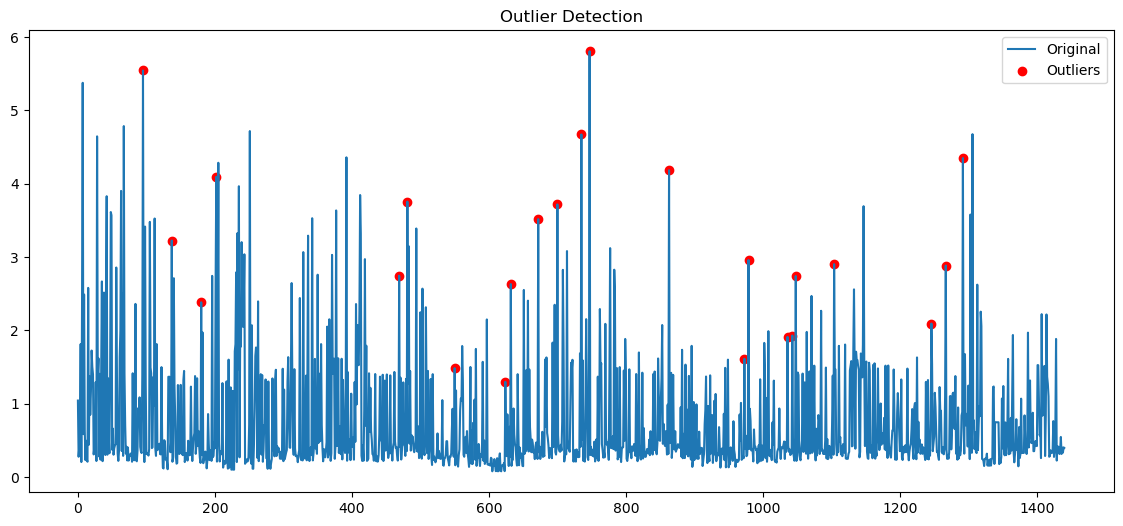

Detected 23 outliers


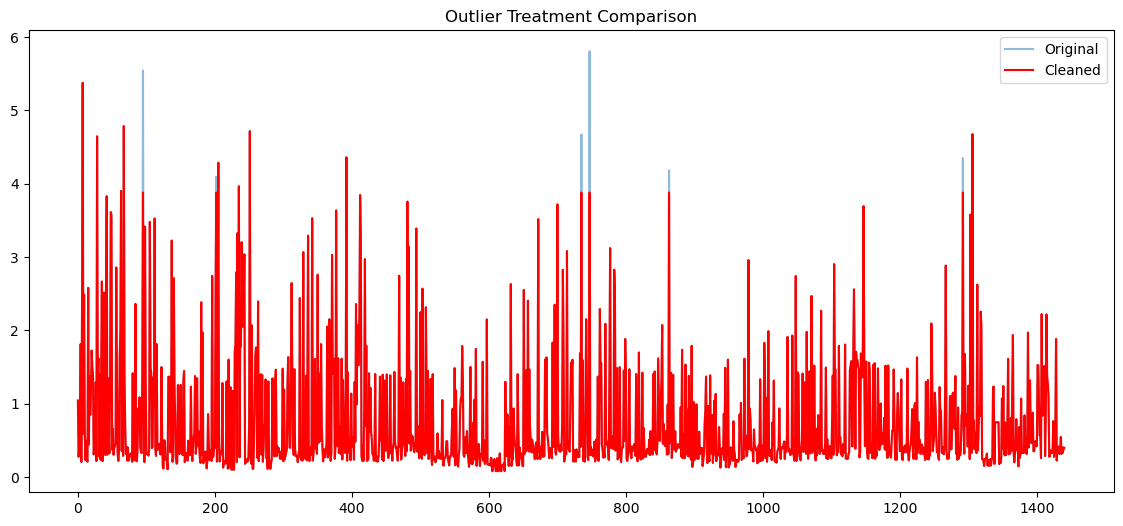

In [226]:
# Select target series
ts = cleaned_df['Global_active_power']

# 1. Detect outliers using rolling z-score (time-aware)
outliers = detect_outliers(ts, method='rolling', window=24, threshold=3)

# 2. Visualize detection
plot_outliers(ts, outliers)
print(f"Detected {outliers.sum()} outliers")

# 3. Handle outliers using winsorizing
cleaned_ts = handle_outliers(ts, outliers, method='winsorize', lower=0.01, upper=0.99)

# 4. Compare results
plt.figure(figsize=(14, 6))
plt.plot(ts, label='Original', alpha=0.5)
plt.plot(cleaned_ts, label='Cleaned', color='red')
plt.title('Outlier Treatment Comparison')
plt.legend()
plt.show()

In [227]:
cleaned_df['Global_active_power1'] = cleaned_ts
cleaned_df['Global_active_power_ln'] = np.log(cleaned_df['Global_active_power1'])
cleaned_df.drop('Global_active_power', axis =1, inplace = True)


In [228]:
cleaned_df.head()

,datetime,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions,Global_active_power1,Global_active_power_ln
0,2006-12-17,0.152,242.73,4.4,0.0,2.0,NaN,3.94,91.1,"Rain, Partially cloudy",1.044,0.043059
1,2006-12-18,0.126,246.17,1.2,0.0,2.0,NaN,4.39,87.5,"Rain, Partially cloudy",0.278,-1.280134
2,2006-12-19,0.242,241.19,2.0,0.0,1.0,NaN,2.44,78.8,Partially cloudy,0.414,-0.881889
3,2006-12-20,0.058,245.57,3.4,0.0,0.0,NaN,2.72,72.3,Partially cloudy,0.824,-0.193585
4,2006-12-21,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy,1.814,0.595534


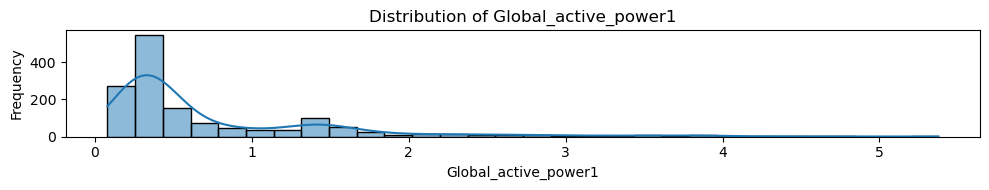

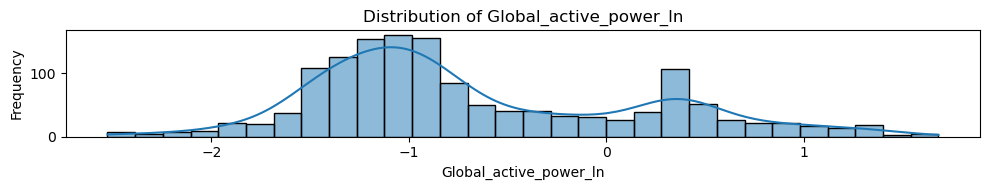

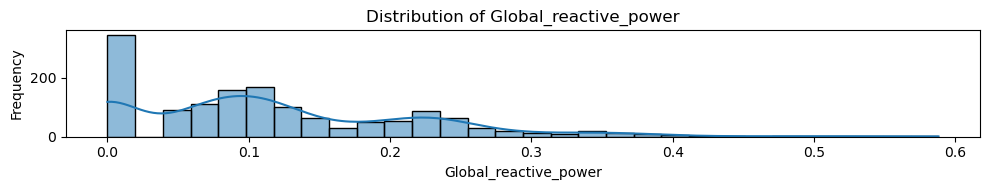

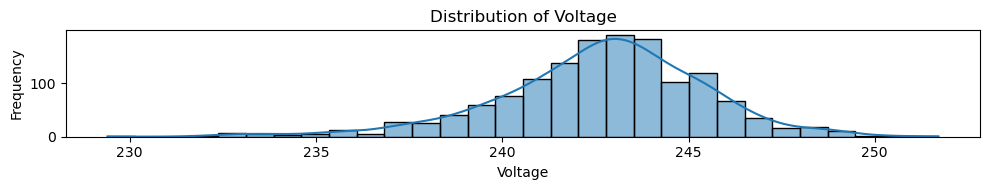

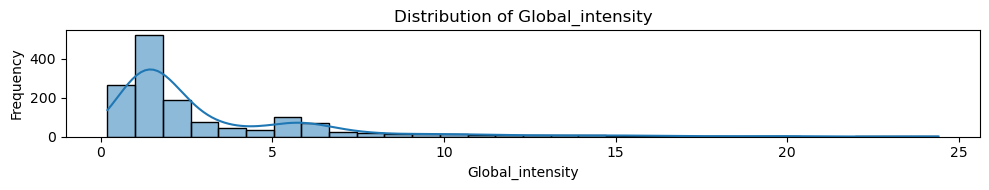

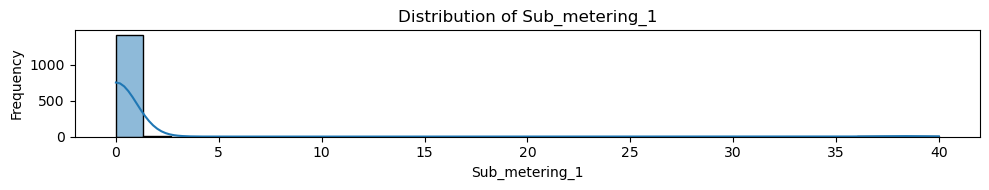

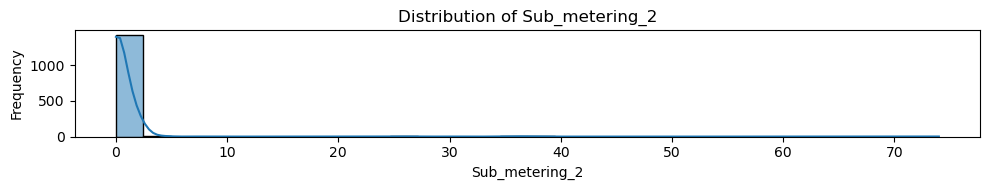

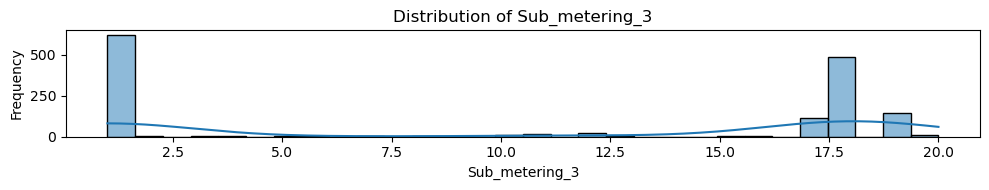

In [229]:
# Distribution of each Variable

def plot_variable_distribution(df):
    for column in columns:
        fig, ax = plt.subplots(figsize=(10, 2))
        sns.histplot(df[column], kde=True, bins=30, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        plt.tight_layout()
        fig.show()

columns = ['Global_active_power1', 'Global_active_power_ln','Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
plot_variable_distribution(cleaned_df)        


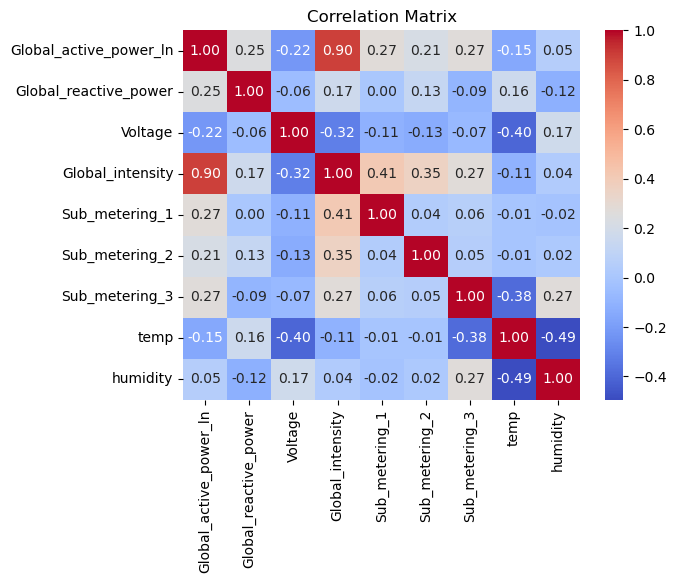

In [230]:
sns.heatmap(cleaned_df[['Global_active_power_ln', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'temp', 'humidity']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [231]:
cleaned_df.head()

,datetime,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions,Global_active_power1,Global_active_power_ln
0,2006-12-17,0.152,242.73,4.4,0.0,2.0,NaN,3.94,91.1,"Rain, Partially cloudy",1.044,0.043059
1,2006-12-18,0.126,246.17,1.2,0.0,2.0,NaN,4.39,87.5,"Rain, Partially cloudy",0.278,-1.280134
2,2006-12-19,0.242,241.19,2.0,0.0,1.0,NaN,2.44,78.8,Partially cloudy,0.414,-0.881889
3,2006-12-20,0.058,245.57,3.4,0.0,0.0,NaN,2.72,72.3,Partially cloudy,0.824,-0.193585
4,2006-12-21,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy,1.814,0.595534



=== Stationarity Test Results for Original Series ===
ADF Test p-value: -6.140342
ADF Critical Values: {'1%': -3.4349634933241084, '5%': -2.8635775363009244, '10%': -2.5678547733584605}
KPSS Test p-value: 0.093547
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ Series is STATIONARY (both tests confirm)


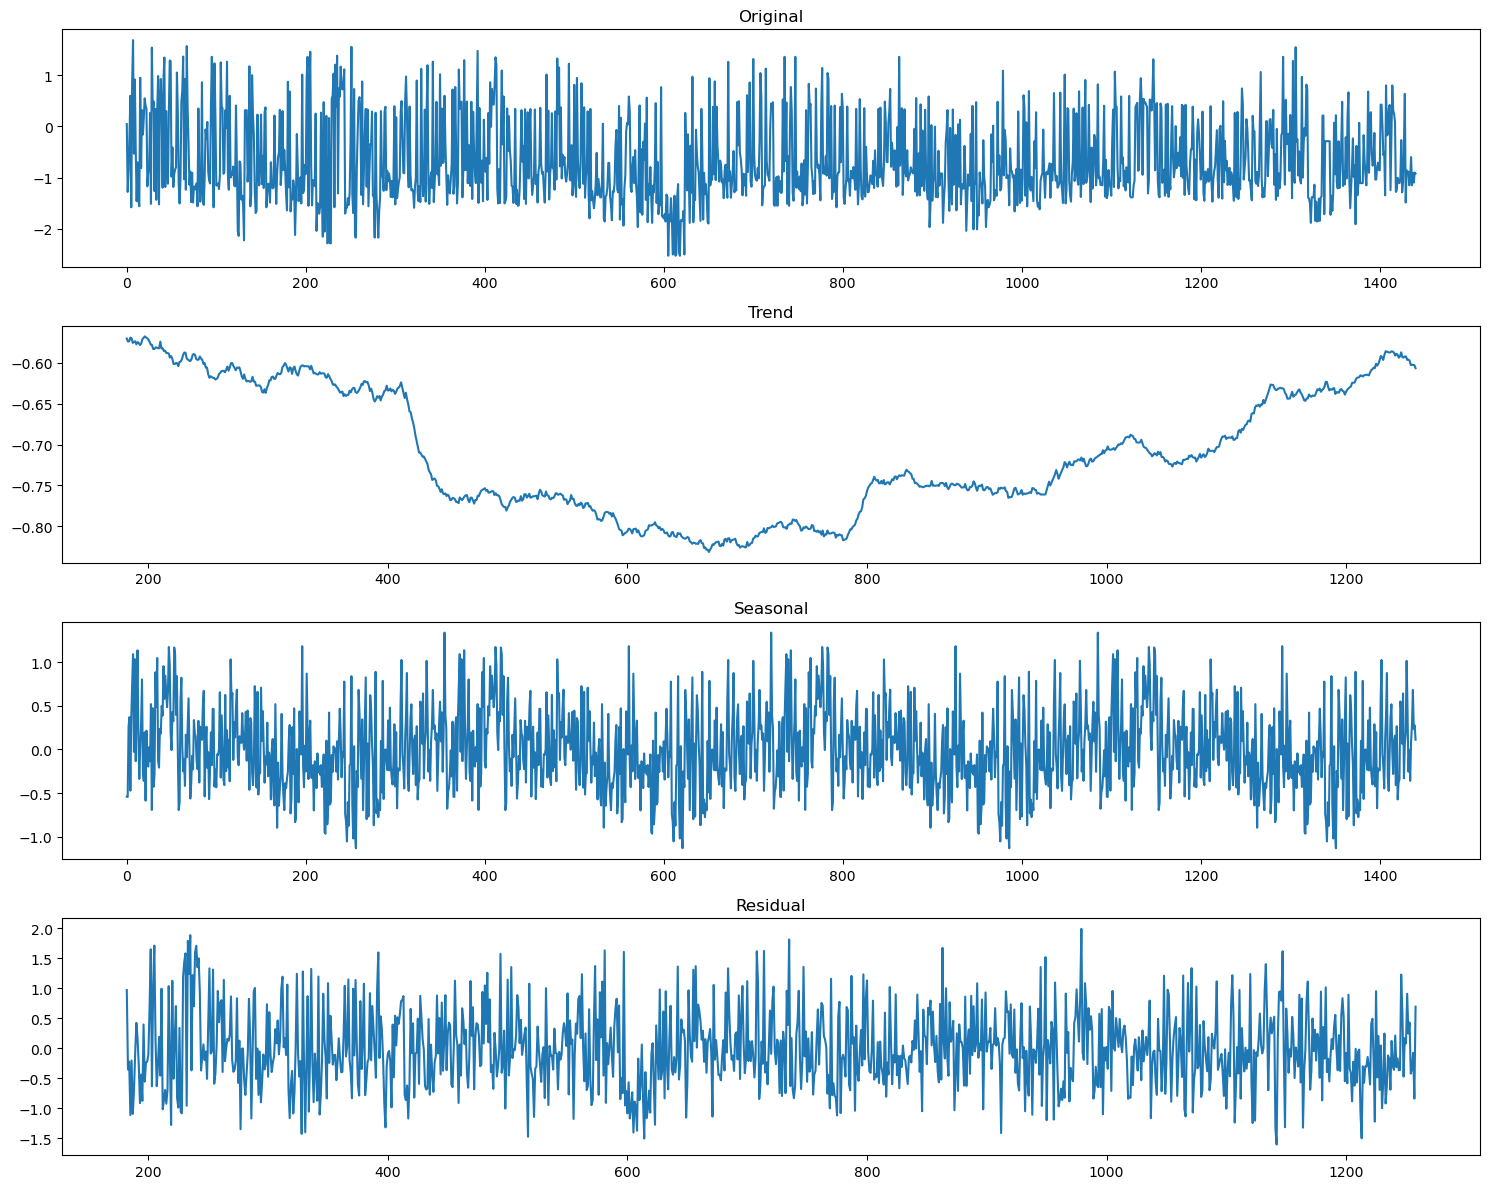

In [232]:
def check_stationarity(timeseries, title):
    """Comprehensive stationarity testing"""
    print(f'\n=== Stationarity Test Results for {title} ===')
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Test p-value: {adf_result[0]:.6f}')
    print(f'ADF Critical Values: {adf_result[4]}')
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print(f'KPSS Test p-value: {kpss_result[1]:.6f}')
    print(f'KPSS Critical Values: {kpss_result[3]}')
    
    # Interpretation
    adf_stationary = adf_result[1] < 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("✅ Series is STATIONARY (both tests confirm)")
    elif not adf_stationary and not kpss_stationary:
        print("❌ Series is NON-STATIONARY (both tests confirm)")
    else:
        print("⚠️  Mixed results - further investigation needed")
    
    return adf_stationary and kpss_stationary

# Test original series
is_stationary = check_stationarity(cleaned_df['Global_active_power_ln'], 'Original Series')

# If not stationary, apply differencing
if not is_stationary:
    df['power_diff'] = df['Global_active_power_ln'].diff()
    df['power_diff2'] = df['power_diff'].diff()
    
    check_stationarity(df['power_diff'].dropna(), 'First Difference')
    check_stationarity(df['power_diff2'].dropna(), 'Second Difference')

# Seasonal decomposition
decomposition = seasonal_decompose(cleaned_df['Global_active_power_ln'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

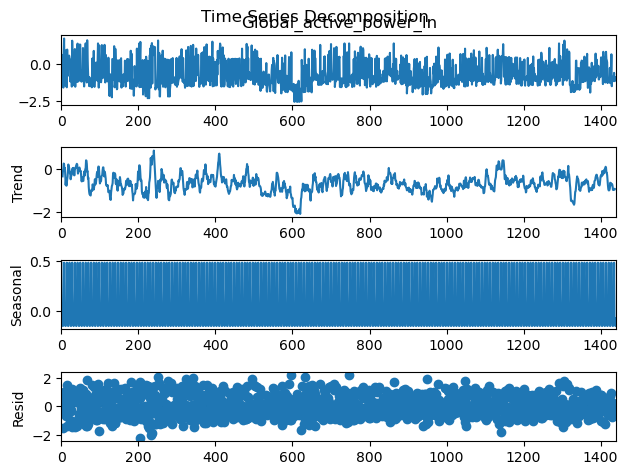

In [233]:
# Time series decomposition
decomp = seasonal_decompose(cleaned_df['Global_active_power_ln'], period=7)
decomp.plot()
plt.suptitle('Time Series Decomposition')
plt.show()

### First Difference

In [234]:
cleaned_df['Global_active_power_diff'] = cleaned_df['Global_active_power_ln'] - cleaned_df['Global_active_power_ln'].shift(1)
cleaned_df.drop('Global_active_power_ln', axis =1, inplace = True)

# Step 2: Drop rows with NaN or infinite values
cleaned_df = cleaned_df.replace([np.inf, -np.inf], np.nan).dropna()

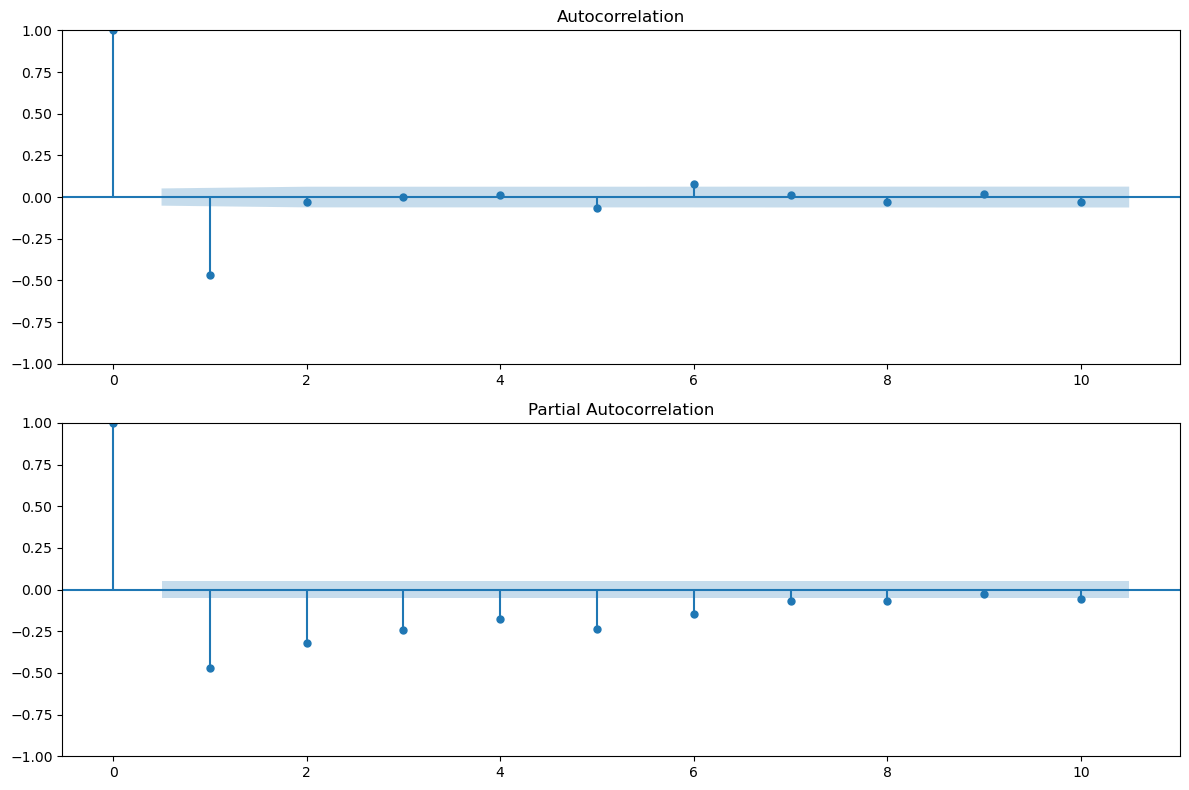

In [235]:
# ACF/PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(cleaned_df['Global_active_power_diff'], lags=10, ax=ax1)
plot_pacf(cleaned_df['Global_active_power_diff'], lags=10, ax=ax2, method='ywm')
plt.tight_layout()
plt.show()


In [236]:
cleaned_df.columns

Index(['datetime', 'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'temp',
       'humidity', 'conditions', 'Global_active_power1',
       'Global_active_power_diff'],
      dtype='object')

In [237]:
# Model training
from sklearn.model_selection import train_test_split
columns = ['Global_active_power_diff', 'Global_reactive_power', 'Voltage',
       'temp', 'humidity']

cleaned_df = cleaned_df[columns]
from sklearn.preprocessing import StandardScaler
train, test = train_test_split(cleaned_df, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop('Global_active_power_diff', axis=1))
X_test = scaler.transform(test.drop('Global_active_power_diff', axis=1))
y_train = train['Global_active_power_diff']
y_test = test['Global_active_power_diff']

In [238]:
# ARIMA
arima_model = ARIMA(y_train, order=(1,0,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))

In [239]:
arima_pred[0:10]

1149    0.713835
1150   -0.338542
1151    0.159371
1152   -0.076207
1153    0.035252
1154   -0.017483
1155    0.007468
1156   -0.004337
1157    0.001248
1158   -0.001394
Name: predicted_mean, dtype: float64

In [240]:
# SARIMA
sarima_model = SARIMAX(y_train, order=(1,0,0), seasonal_order=(0,0,0,7))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(steps=len(y_test))

In [241]:
sarima_pred[0:10]

1149    0.714650
1150   -0.338129
1151    0.159982
1152   -0.075694
1153    0.035814
1154   -0.016945
1155    0.008017
1156   -0.003793
1157    0.001795
1158   -0.000849
Name: predicted_mean, dtype: float64

In [242]:
# Evaluation
results = []
for name, pred in zip(['ARIMA', 'SARIMA'], [arima_pred, sarima_pred]):
    mae = mean_absolute_error(y_test, pred)
    results.append({'Model':name, 'MAE':mae})
    
results_df = pd.DataFrame(results)
print("\nModel Performance:\n", results_df.sort_values('MAE'))


Model Performance:
     Model       MAE
1  SARIMA  0.657673
0   ARIMA  0.657713


In [243]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Feature selection
columns = ['Global_active_power_diff', 'Global_reactive_power', 'Voltage', 'temp', 'humidity']
cleaned_df = cleaned_df[columns]

# Step 3: Train-test split
train, test = train_test_split(cleaned_df, test_size=0.2, shuffle=False)

# Step 4: Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop('Global_active_power_diff', axis=1))
X_test = scaler.transform(test.drop('Global_active_power_diff', axis=1))
y_train = train['Global_active_power_diff'].values
y_test = test['Global_active_power_diff'].values

# Step 5: Train model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 6: Predict
y_pred = xgb_model.predict(X_test)

# Step 7: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")



XGBoost Performance:
MAE:  0.6884
RMSE: 0.8919
R²:   -0.0171


14:07:58 - cmdstanpy - INFO - Chain [1] start processing
14:07:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance:
MAE:  0.6884
RMSE: 0.8919
R²:   -0.0171


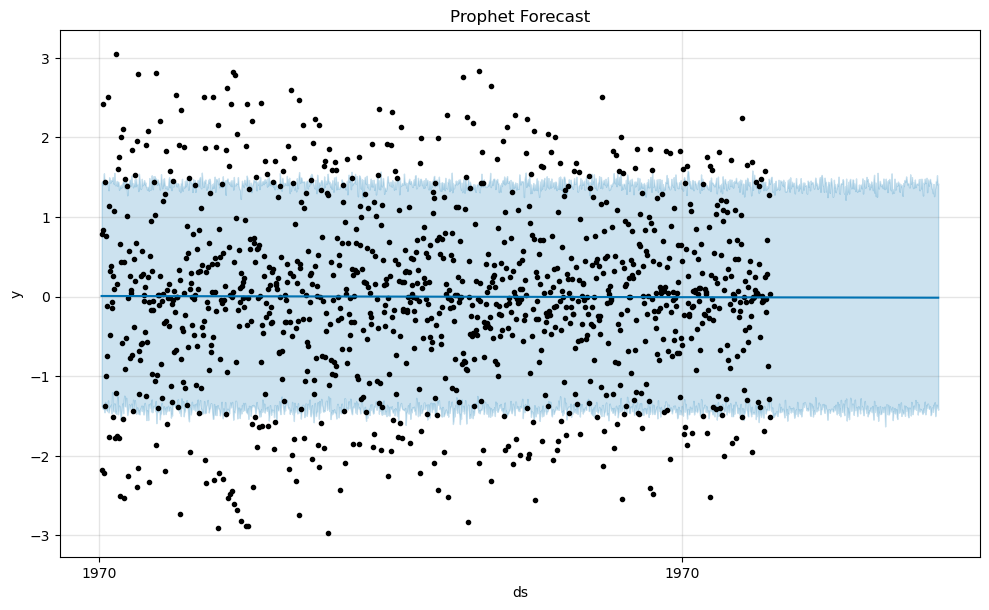

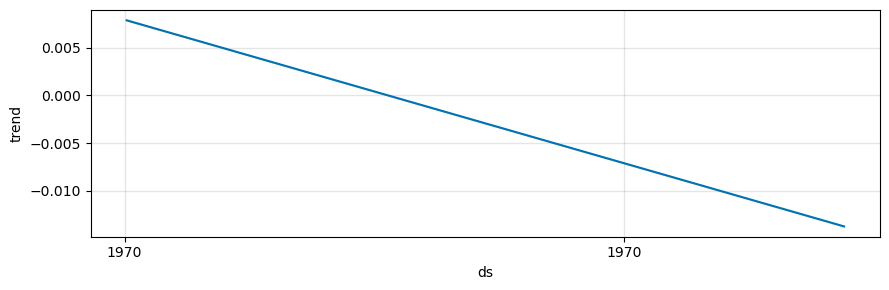

In [245]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
prophet_df = cleaned_df.copy().reset_index()
prophet_df.rename(columns={'index': 'ds', 'Global_active_power_diff': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')
prophet_df = prophet_df.dropna(subset=['ds', 'y'])

# Detect frequency
freq = pd.infer_freq(prophet_df['ds'].sort_values()) or 'D'

# Split
split_idx = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:split_idx]
test_df = prophet_df.iloc[split_idx:]

# Fit Prophet
model = Prophet()
model.fit(train_df)

# Forecast
future = model.make_future_dataframe(periods=len(test_df), freq=freq)
forecast = model.predict(future)

# Step 7: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Prophet Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

model.plot_components(forecast)
plt.show()

